# 1. 線形回帰

In [14]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

## 1.1　線形回帰

In [15]:
def linear(X, y):
    p = X.shape[1]
    x_bar = np.zeros(p)
    for j in range(p):
        x_bar[j] = np.mean(X[:, j])
    for j in range(p):
        X[:, j] = X[:, j] - x_bar[j]      # Xの中心化
    y_bar = np.mean(y)
    y = y - y_bar                         # yの中心化
    beta = np.dot(
        np.linalg.inv(np.dot(X.T, X)),
        np.dot(X.T, y)
    )
    beta_0 = y_bar - np.dot(x_bar, beta)
    return beta, beta_0

## 1.2　劣微分

### 例1

Text(0.5, 1.0, '$y = x^2 - 3x + |x|$')

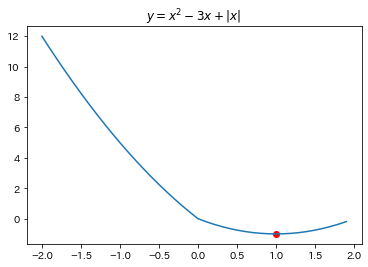

In [16]:
x = np.arange(-2, 2, 0.1)
y = x**2 - 3 * x + np.abs(x)
plt.plot(x, y)
plt.scatter(1, -1, c="red")
plt.title("$y = x^2 - 3x + |x|$")

Text(0.5, 1.0, '$y = x^2 + x + 2|x|$')

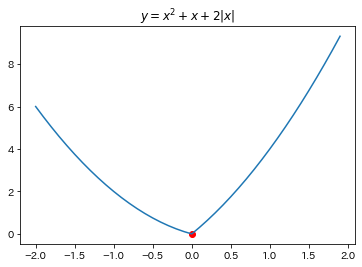

In [17]:
x = np.arange(-2, 2, 0.1)
y = x**2 + x + 2 * np.abs(x)
plt.plot(x, y)
plt.scatter(0, 0, c="red")
plt.title("$y = x^2 + x + 2|x|$")

## 1.3　Lasso

In [18]:
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, np.zeros(1))

Text(-2, 1, '$\\lambda=5$')

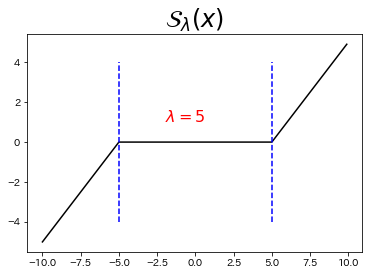

In [19]:
x = np.arange(-10, 10, 0.1)
y = soft_th(5, x)
plt.plot(x, y, c="black")
plt.title(r"${\cal S}_\lambda(x)$", size=24)
plt.plot([-5, -5], [-4, 4], c="blue", linestyle="dashed")
plt.plot([5, 5], [-4, 4], c="blue", linestyle="dashed")
plt.text(-2, 1, r"$\lambda=5$", c="red", size=16)

In [20]:
def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化（下記参照）
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

In [21]:
def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Xの各列の平均
    X_sd = np.zeros(p)                    # Xの各列の標準偏差
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Xの各列の中心化
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Xの各列の標準化
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # yの平均
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # yの中心化
    else:                                 # yがベクトルの場合
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

### 例2

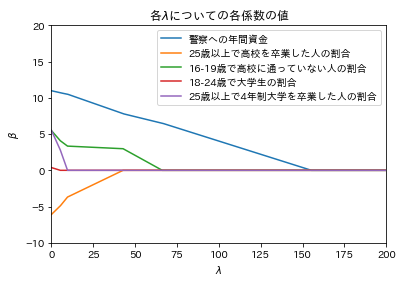

In [22]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.1)
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta$")
plt.title(r"各$\lambda$についての各係数の値")
labels = ["警察への年間資金", "25歳以上で高校を卒業した人の割合",
          "16-19歳で高校に通っていない人の割合",
          "18-24歳で大学生の割合", "25歳以上で4年制大学を卒業した人の割合"]
r = len(lambda_seq)
coef_seq = np.zeros((r, p))
for i in range(r):
    coef_seq[i, :], _ = linear_lasso(X, y, lambda_seq[i])
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j], label=labels[j])
plt.legend(loc="upper right")

In [23]:
def warm_start(X, y, lambda_max=100):
    dec = np.round(lambda_max / 50)
    lambda_seq = np.arange(lambda_max, 1, -dec)
    r = len(lambda_seq)
    p = X.shape[1]
    beta = np.zeros(p)
    coef_seq = np.zeros((r, p))
    for k in range(r):
        beta, _ = linear_lasso(X, y, lambda_seq[k], beta)
        coef_seq[k, :] = beta
    return coef_seq

### 例3

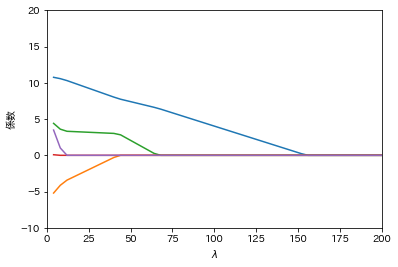

In [24]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
coef_seq = warm_start(X, y, 200)
lambda_max = 200
dec = round(lambda_max / 50)
lambda_seq = np.arange(lambda_max, 1, -dec)
plt.ylim(np.min(coef_seq), np.max(coef_seq))
plt.xlabel(r"$\lambda$")
plt.ylabel("係数")
plt.xlim(0, 200)
plt.ylim(-10, 20)
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j])

### 例4

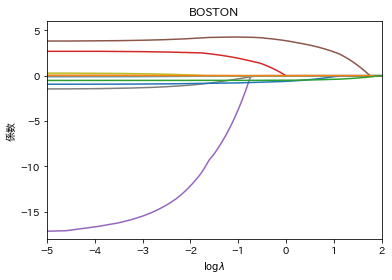

In [25]:
from sklearn.datasets import load_boston
boston = load_boston()
x = boston.data
y = boston.target
n, p = x.shape
lambda_seq = np.arange(0.0001, 20, 0.01)
r = len(lambda_seq)
plt.xlim(-5, 2)
plt.ylim(-18, 6)
plt.xlabel(r"$\log \lambda$")
plt.ylabel("係数")
plt.title("BOSTON")
coef_seq = np.zeros((r, p))
for i in range(r):
    coef_seq[i, :], _ = linear_lasso(x, y, lam=lambda_seq[i])
for j in range(p):
    plt.plot(np.log(lambda_seq), coef_seq[:, j])

## 1.4　Ridge

In [26]:
def ridge(X, y, lam=0):
    n, p = X.shape
    X, y, X_bar, X_sd, y_bar = centralize(X, y)
    beta = np.dot(
        np.linalg.inv(np.dot(X.T, X) + n * lam * np.eye(p)),
        np.dot(X.T, y)
    )
    beta = beta / X_sd
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

### 例5

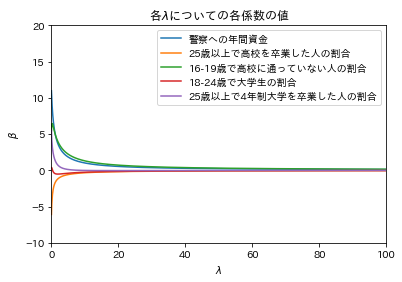

In [27]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.1)
plt.xlim(0, 100)
plt.ylim(-10, 20)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta$")
plt.title(r"各$\lambda$についての各係数の値")
labels = ["警察への年間資金", "25歳以上で高校を卒業した人の割合",
          "16-19歳で高校に通っていない人の割合",
          "18-24歳で大学生の割合", "25歳以上で4年制大学を卒業した人の割合"]
r = len(lambda_seq)
beta = np.zeros(p)
coef_seq = np.zeros((r, p))
for i in range(r):
    beta, beta_0 = ridge(X, y, lambda_seq[i])
    coef_seq[i, :] = beta
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j], label=labels[j])
plt.legend(loc="upper right")

In [28]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
y = df[:, 0]
linear(X, y)

(array([10.98067026, -6.08852939,  5.4803042 ,  0.37704431,  5.50047122]),
 489.6485969690334)

In [29]:
ridge(X, y)

(array([10.98067026, -6.08852939,  5.4803042 ,  0.37704431,  5.50047122]),
 717.96)

In [30]:
ridge(X, y, 200)

(array([ 0.0563518 , -0.01976397,  0.07786309, -0.0171218 , -0.0070393 ]),
 717.96)

## 1.5　LassoとRidgeを比較して

### 例6

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

In [32]:
def R2(x, y):
    model = LinearRegression()
    model.fit(x, y)           # モデルの訓練
    y_hat = model.predict(x)  # 予測値の表示
    y_bar = np.mean(y)
    RSS = np.dot(y - y_hat, y - y_hat)
    TSS = np.dot(y - y_bar, y - y_bar)
    return 1 - RSS / TSS

In [33]:
def vif(x):
    p = x.shape[1]
    values = np.zeros(p)
    for j in range(p):
        ind = [i for i in range(p) if i != j]
        values[j] = 1 / (1 - R2(x[:, ind], x[:, j]))
    return values

In [34]:
boston = load_boston()
n = boston.data.shape[0]
z = np.concatenate([boston.data, boston.target.reshape([n, 1])], 1)
vif(z)

array([1.83153668, 2.35218589, 3.99250315, 1.09522267, 4.58692024,
       2.26037436, 3.10084282, 4.39600725, 7.80819843, 9.20554209,
       1.99301566, 1.38146295, 3.5815848 , 3.85568427])

### 例7

Text(0.5, 1.0, 'Lasso')

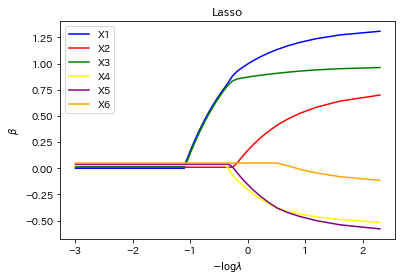

In [35]:
n = 500
x = np.zeros((n, 6))
z = np.zeros((n, 5))
for k in range(2):
    z[:, k] = np.random.randn(n)
y = 3 * z[:, 0] - 1.5 * z[:, 1] + 2 * np.random.randn(n)
for j in range(3):
    x[:, j] = z[:, 0] + np.random.randn(n) / 5
for j in range(3, 6):
    x[:, j] = z[:, 1] + np.random.randn(n) / 5
lambda_seq = np.arange(0.1, 20, 0.1)
p = 6
r = len(lambda_seq)
coef_seq = np.zeros((r, p))
cols = ["blue", "red", "green", "yellow", "purple", "orange"]
for i in range(r):
    coef_seq[i, :], _ = linear_lasso(x, y, lambda_seq[i])
for j in range(p):
    plt.plot(-np.log(lambda_seq), coef_seq[:, j] + 0.01 * j,
             c=cols[j], label="X"+str(j+1))
plt.xlabel(r"$-\log \lambda$")
plt.ylabel(r"$\beta$")
plt.legend(loc="upper left")
plt.title("Lasso")

## 1.6　elasticネット

In [36]:
def elastic_net(X, y, lam=0, alpha=1, beta=None):                     #
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n)                                    ##
            beta[j] = (soft_th(lam * alpha, z)                              ##
                       / (np.dot(X[:, j], X[:, j]) / n + (1-alpha) * lam))  ##
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

## 1.7　$\lambda$の値の設定

In [37]:
def cv_linear_lasso(x, y, alpha=1, k=10):
    lam_max = np.max(np.dot(x.T, y) / np.dot(x.T, x))
    lam_seq = np.array(range(100))**3 / 1000000 * lam_max
    n = len(y)
    m = int(n / k)
    r = n % k
    S_min = np.inf
    for lam in lam_seq:
        S = 0
        for i in range(k):
            if i < k - r:
                index = list(range(i*m, i*m + m))
            else:
                index = list(range(i*m + (i-k+r), i*m + (m+i-k+r+1)))
                # nをkで割れない場合
            _index = list(set(range(n)) - set(index))
            beta, beta0 = elastic_net(x[_index, ], y[_index], lam, alpha)
            z = np.linalg.norm((y[index] - beta0 - np.dot(x[index], beta)), 2)
            S = S + z**2
        if S < S_min:
            S_min = S.copy()
            lam_best = lam.copy()
            beta0_best = beta0.copy()
            beta_best = beta.copy()
    return lam_best, beta0_best, beta_best, S_min

### 例9

21.98869501247591
526.7401583585395
[ 9.49890024 -3.79670916  2.65033978 -0.          0.        ]


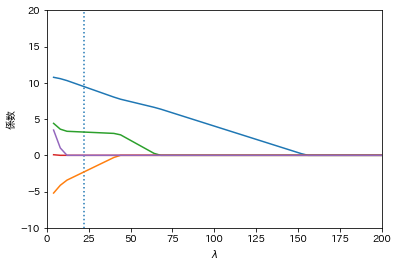

In [38]:
df = np.loadtxt("crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lam, beta0, beta, S = cv_linear_lasso(X, y)
print(lam)
print(beta0)
print(beta)
coef_seq = warm_start(X, y, 200)
lambda_max = 200
dec = round(lambda_max / 50)
lambda_seq = np.arange(lambda_max, 1, -dec)
plt.ylim(np.min(coef_seq), np.max(coef_seq))
plt.xlabel(r"$\lambda$")
plt.ylabel("係数")
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.axvline(x=lam, ymin=-10, ymax=10, linestyle="dotted")
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j])

### 例10

In [39]:
def cv_elastic_net(x, y, k=10):
    alpha_seq = np.array(range(100)) / 100
    S_min = np.inf
    for alpha in alpha_seq:
        lam, beta0, beta, S = cv_linear_lasso(x, y, alpha)
        if S < S_min:
            S_min = S
            alpha_best = alpha
            lam_best = lam
            beta0_best = beta0
            beta_best = beta
    return alpha_best, lam_best, beta0_best, beta_best, S_min

In [40]:
n = 500
x = np.zeros((n, 6))
z = np.zeros((n, 5))
for k in range(2):
    z[:, k] = np.random.randn(n)
y = 3 * z[:, 0] - 1.5 * z[:, 1] + 2 * np.random.randn(n)
for j in range(3):
    x[:, j] = z[:, 0] + np.random.randn(n) / 5
for j in range(3, 6):
    x[:, j] = z[:, 1] + np.random.randn(n) / 5

In [41]:
alpha, lam, beta0, beta, S = cv_elastic_net(x, y)
print(alpha)
print(lam)
print(beta0)
print(beta)
# 時間がかかる（10分程度）

0.0
0.07636799691155091
-0.020582824091552
[ 0.77568079  1.14257326  1.03536249 -0.54964339 -0.35540394 -0.49063176]


In [42]:
cv_linear_lasso(x, y, 0.25)

(0.07636799691155091,
 -0.020367884263985073,
 array([ 0.73398566,  1.17520274,  1.04354444, -0.5612607 , -0.33182014,
        -0.49139394]),
 2382.6316044668015)

In [43]:
cv_linear_lasso(x, y, 0.5)

(0.07636799691155091,
 -0.020124266748431235,
 array([ 0.67244374,  1.22379046,  1.05542663, -0.57926562, -0.29921315,
        -0.4945385 ]),
 2385.864426283833)

In [44]:
cv_linear_lasso(x, y, 0.75)

(0.05567226974852061,
 -0.020777844835074943,
 array([ 0.54232183,  1.34112674,  1.08802579, -0.62878132, -0.23764369,
        -0.51407225]),
 2391.1520437702034)

In [45]:
cv_linear_lasso(x, y, 1)

(0.004887551802339258,
 -0.023039788718631354,
 array([ 0.41357172,  1.47910418,  1.1307513 , -0.69376697, -0.18317412,
        -0.55021365]),
 2396.9050213533174)